# Part 6.5 - Analysis Topic Model of ADs
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [2]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
#plt.style.use('seaborn-darkgrid')
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline

**In this part, we will use the topic modeling result from part 6.1 to analyze the topics of different label (ADs).** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [3]:
path = r'../models/ads/topicKeys.csv'

df_topics = (pd.read_csv(path, 
                         header=None, 
                         index_col=None, 
                         names = ['topic_', 'weight_', 'keywords_'],
                         encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [4]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
0,0,0.001753,theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...
1,1,0.005088,day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...
2,2,0.001866,election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...
3,3,0.004790,oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...
4,4,0.004740,christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...


**Docmument - dominant topics dataframe:**

In [5]:
path = r'../models/ads/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [6]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (504386, 6)


,id,region,year,topic,weight,keywords
23731,2581187,Manawatu-Wanganui,1879,8,0.107378,business public begs orders stock notice attention inform pr...
466158,28960504,Hawke's Bay,1885,164,0.091421,letter sir editor made public matter statement time paper fa...
227309,12163817,Otago,1898,28,0.216222,tin ill oil day lit zealand ton mil tie aro hat fur aid ail ...
364173,24370327,Taranaki,1915,28,0.095554,tin ill oil day lit zealand ton mil tie aro hat fur aid ail ...
15868,2343617,Bay of Plenty,1883,127,0.103668,books goods fancy christmas stock cards large toys cases xma...


**Average topic weight dataframe:**

In [7]:
path = r'../models/ads/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [8]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


,year,topic,weight,keywords
15963,1921,163,0.002689,found death body deceased man named inquest died dead mornin...
4863,1863,63,0.008289,cases case casks boxes ditto sale bags oil brandy sugar ale ...
9833,1888,33,0.003259,accident train car railway road injured driver killed horse ...
3077,1854,77,0.001256,day notice district office act board court held april county...
12838,1903,38,0.002721,wanted apply anted office good street mrs address sale gener...


## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [9]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

,id,region,year,topic,weight,keywords
311869,18086539,Wellington,1926,28,0.964668,tin ill oil day lit zealand ton mil tie aro hat fur aid ail ...
872,1883336,Otago,1867,125,0.919611,tea teas coffee tobacco cocoa pure ceylon advertisements col...
201,1860837,Otago,1865,125,0.842437,tea teas coffee tobacco cocoa pure ceylon advertisements col...


In [10]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

18086539

In [11]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 18086539
1069296:18086539	Page 2 Advertisements Column 5	"J)E LUXE COMMENCING FRIDAY NEXT! THE MIGHTY WILLIAM FOX EPIC OF THE SCREEN. HAVO4 HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC! HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC\" HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC rr ' HAVOC HAVOC HAVO

## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the first 20 topics in topics list.**

In [12]:
df_plt = df_topics.copy(deep=True)

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords'].map(addWeight)

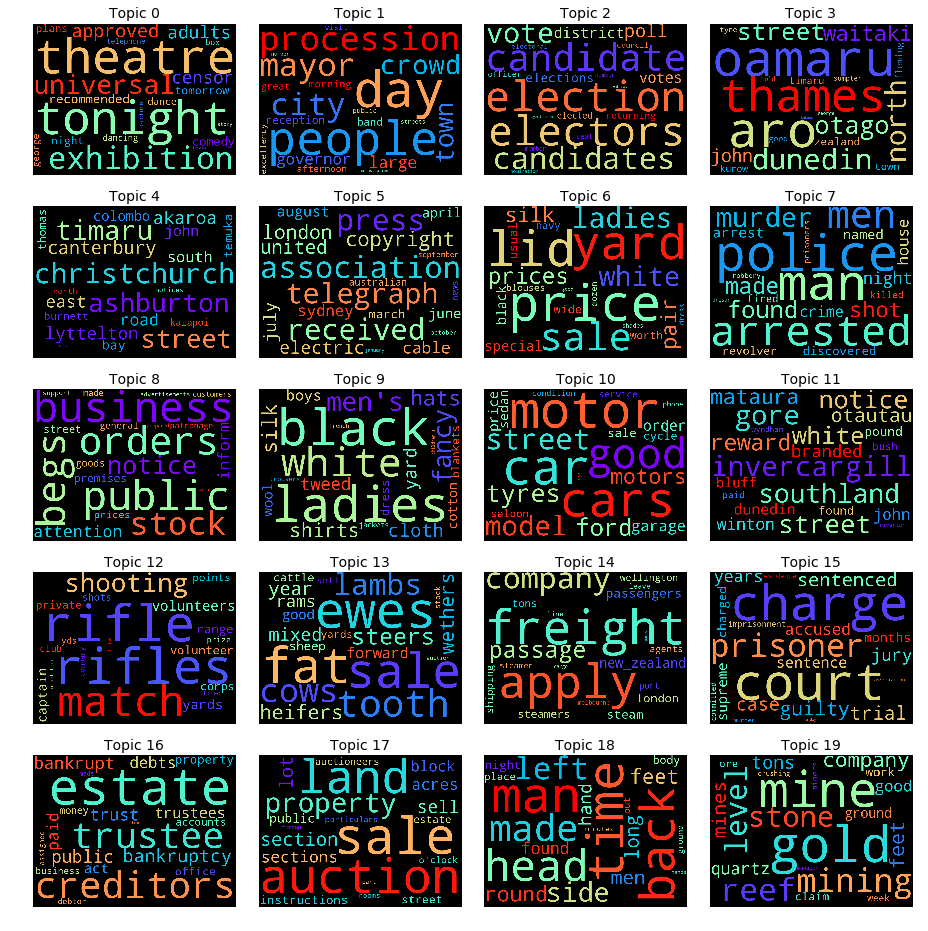

In [13]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

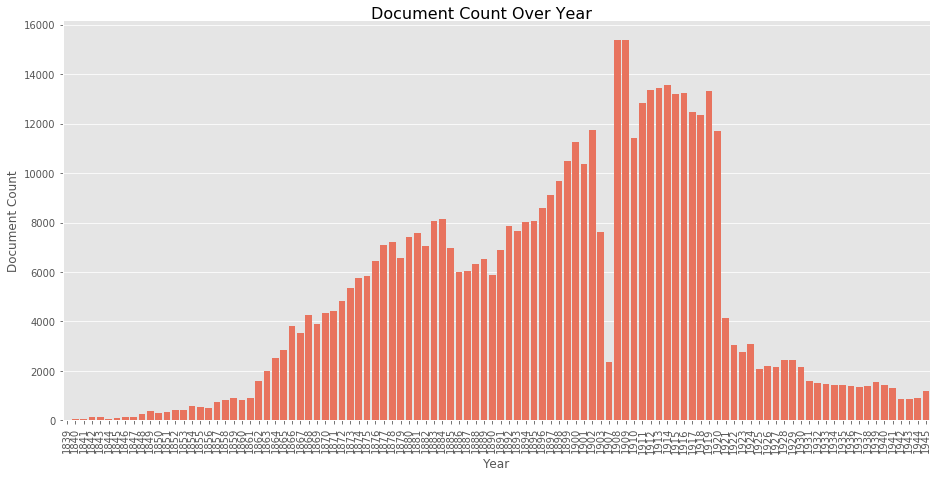

In [14]:
g = sns.catplot(x="year", color='tomato',
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Year", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Year', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general.**

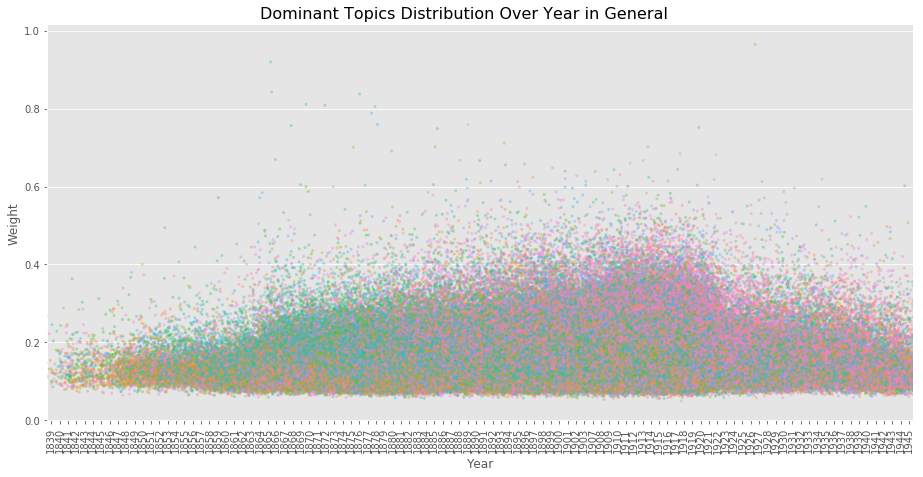

In [15]:
g = sns.catplot(x="year", y='weight', hue='topic',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.4, edgecolors='w',
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Year in General", fontsize=16)
g.set(xlabel='Year', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

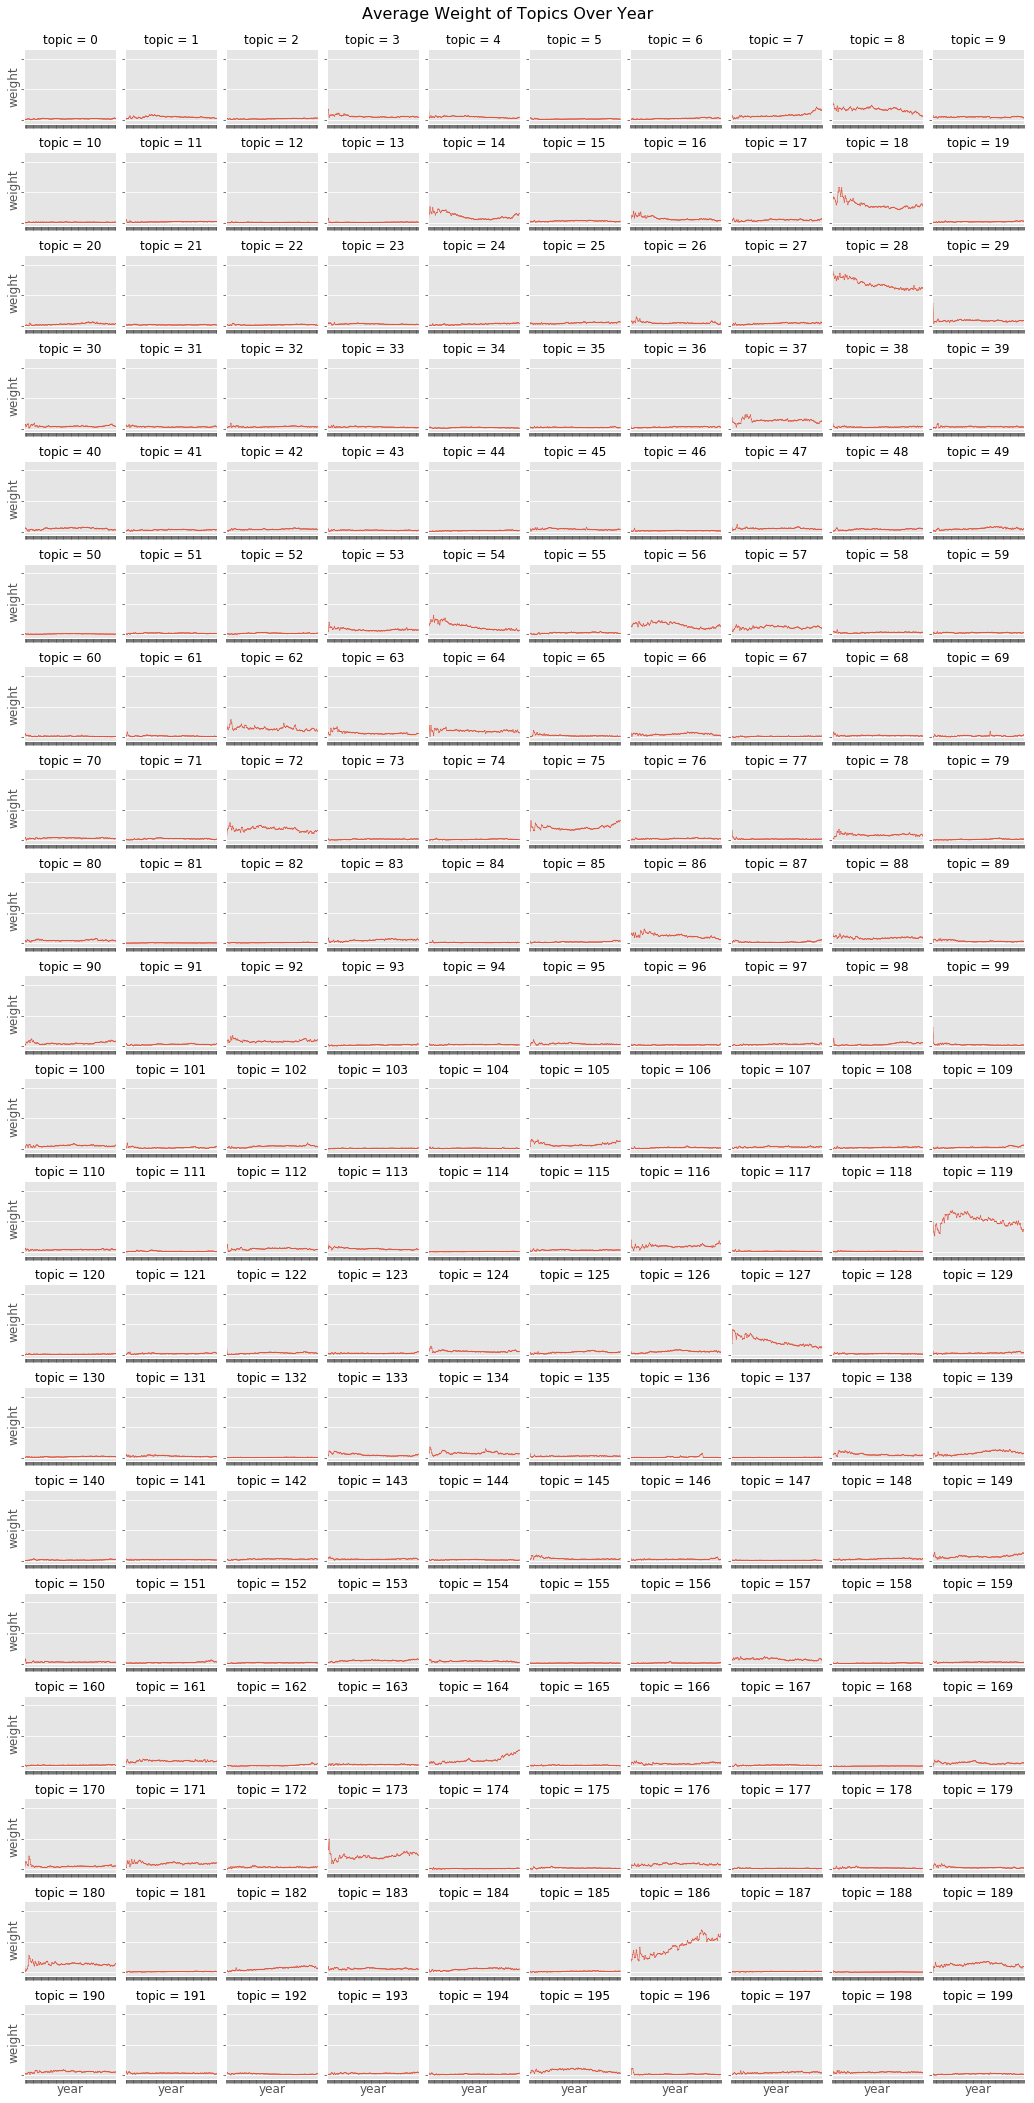

In [16]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Average Weight of Topics Over Year", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [17]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (12978, 6)
Shape of df_plt_avg: (1040, 4)


,weight,keywords
topic,,
0,0.001753,theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...
1,0.005088,day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...
2,0.001866,election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...
3,0.004790,oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...
4,0.004740,christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...
5,0.001394,association press received telegraph copyright london united electric july cable sydney august june april march aust...
6,0.002418,price lid yard sale ladies white prices pair silk special black usual wide worth navy blouses dozen dress shades good
7,0.007273,police man arrested men murder found made shot night house crime arrest named discovered revolver fired killed priso...
8,0.017790,business public begs orders stock notice attention inform premises street prices goods general made patronage custom...


**Dominant topics distribution over year:**

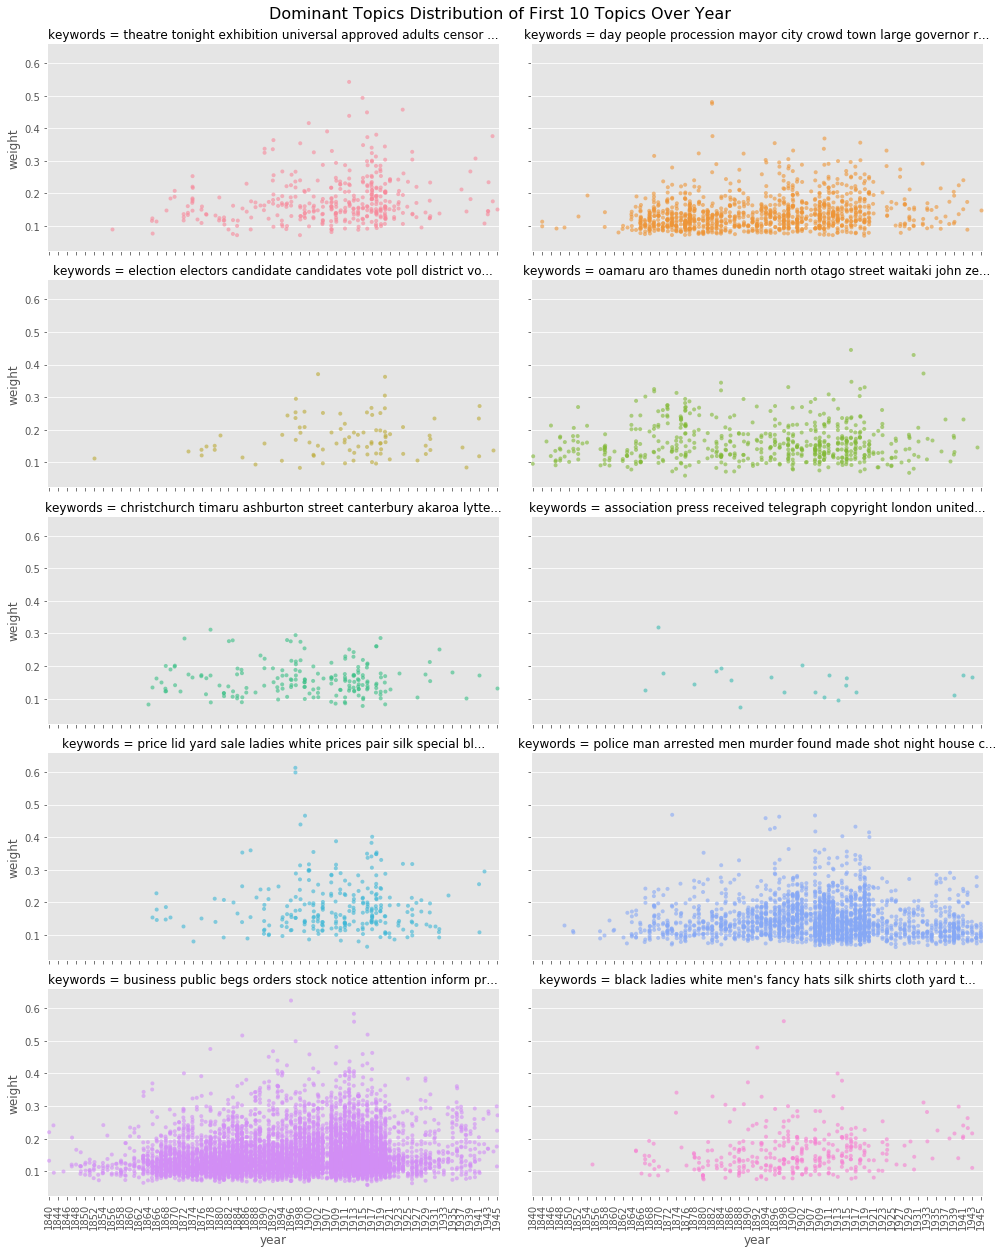

In [18]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

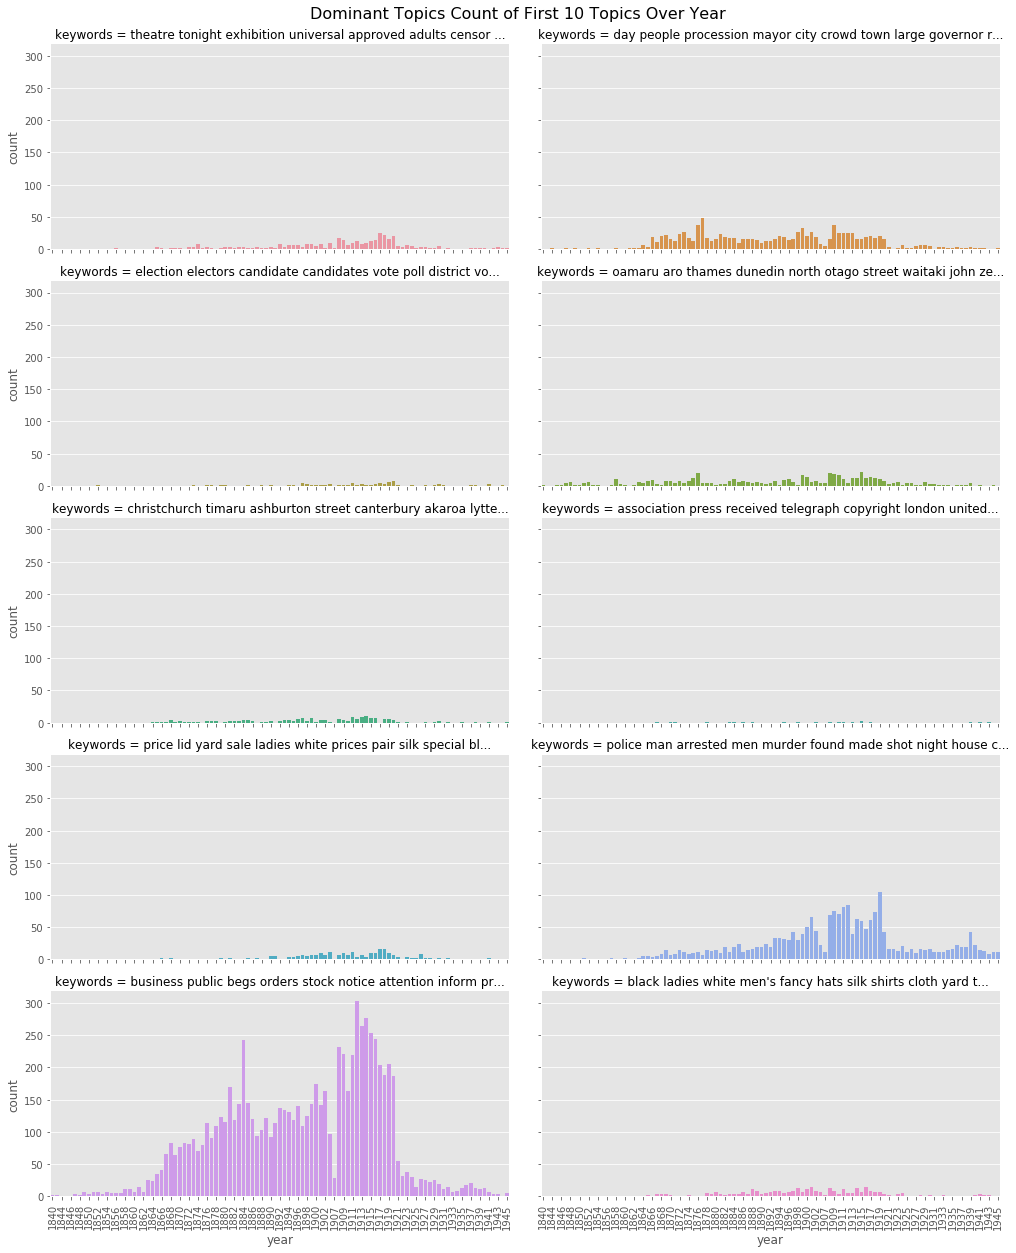

In [19]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

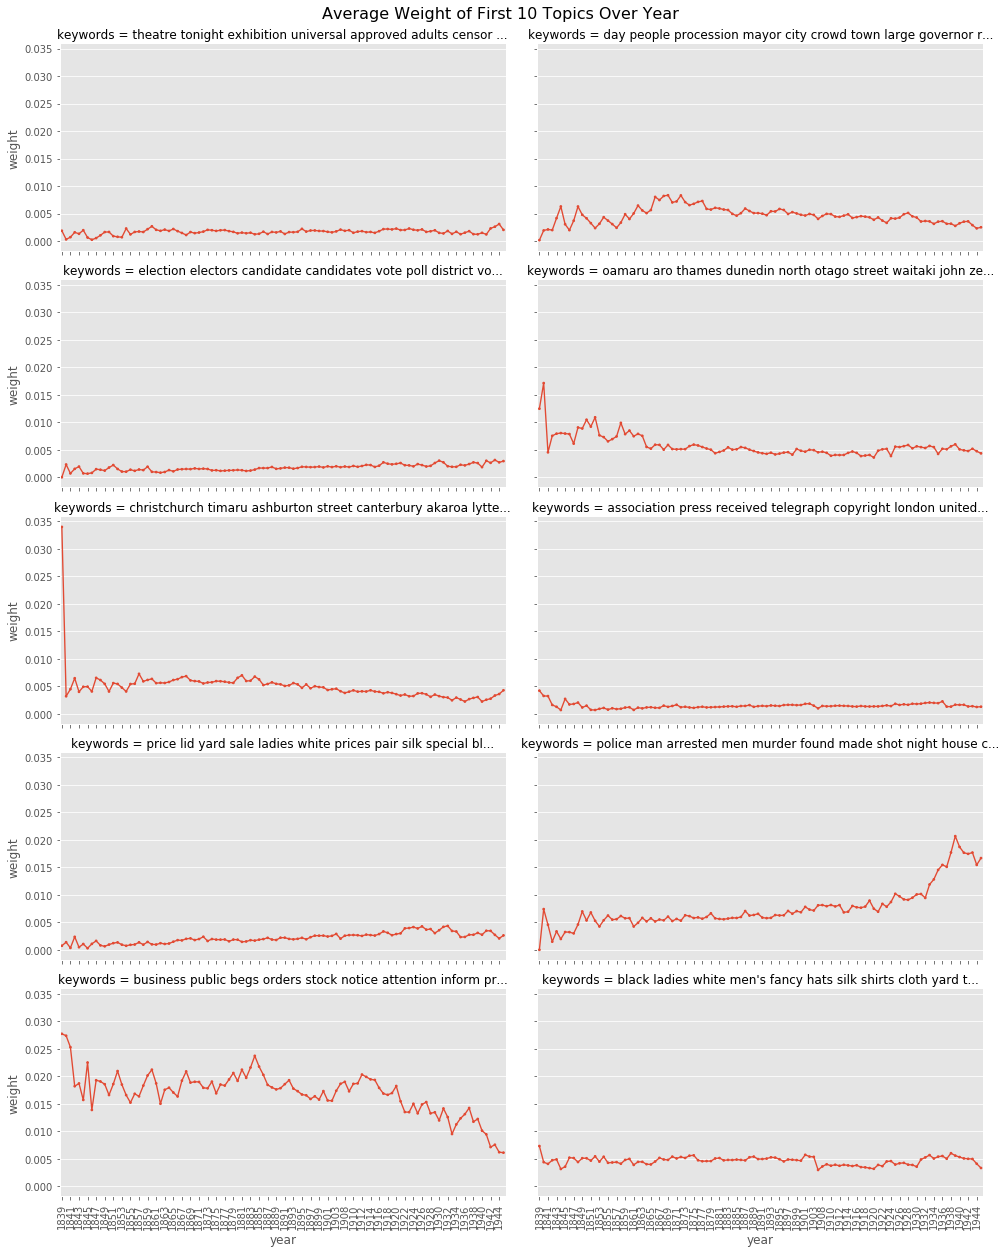

In [20]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

## 5 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [21]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])
signif_topic_list = topic_list

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [119, 186, 28, 18, 72, 173, 62, 8, 189, 86]
Shape of df_plt_dom: (333939, 6)
Shape of df_plt_avg: (1040, 4)


,weight,keywords
topic,,
119,0.053376,public people men question great time good law country man present fact matter state opinion case system means gover...
186,0.044588,man life great years world men time people work english human history good made fact long character nature modern mind
28,0.065143,tin ill oil day lit zealand ton mil tie aro hat fur aid ail man end tins wai hut time
18,0.026226,time man back head made left side round feet men long hand found night body place put ground minutes hands
72,0.019416,meeting evening yesterday held morning messrs night saturday wellington made number court district company local wee...
173,0.020456,love life heart day thy god world man eyes thou light long night earth great sweet thee death men home
62,0.014831,miles river country water lake road great found bush side sea party place mountain distance island land valley feet ...
8,0.017790,business public begs orders stock notice attention inform premises street prices goods general made patronage custom...
189,0.014265,books book published illustrated new_zealand library history works london edition life vols family price magazine pa...


**Dominant topics distribution over year:**

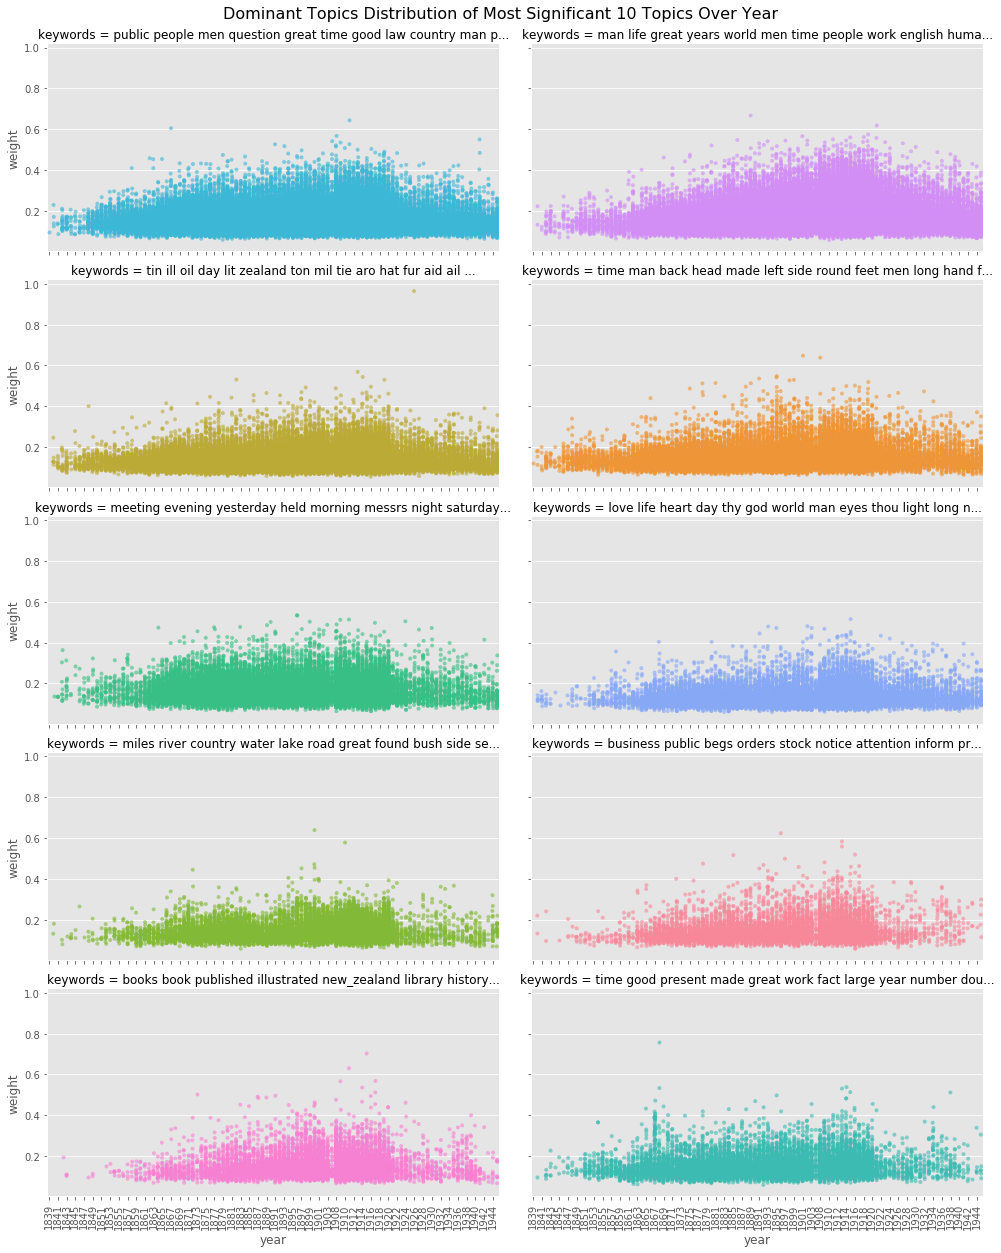

In [22]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

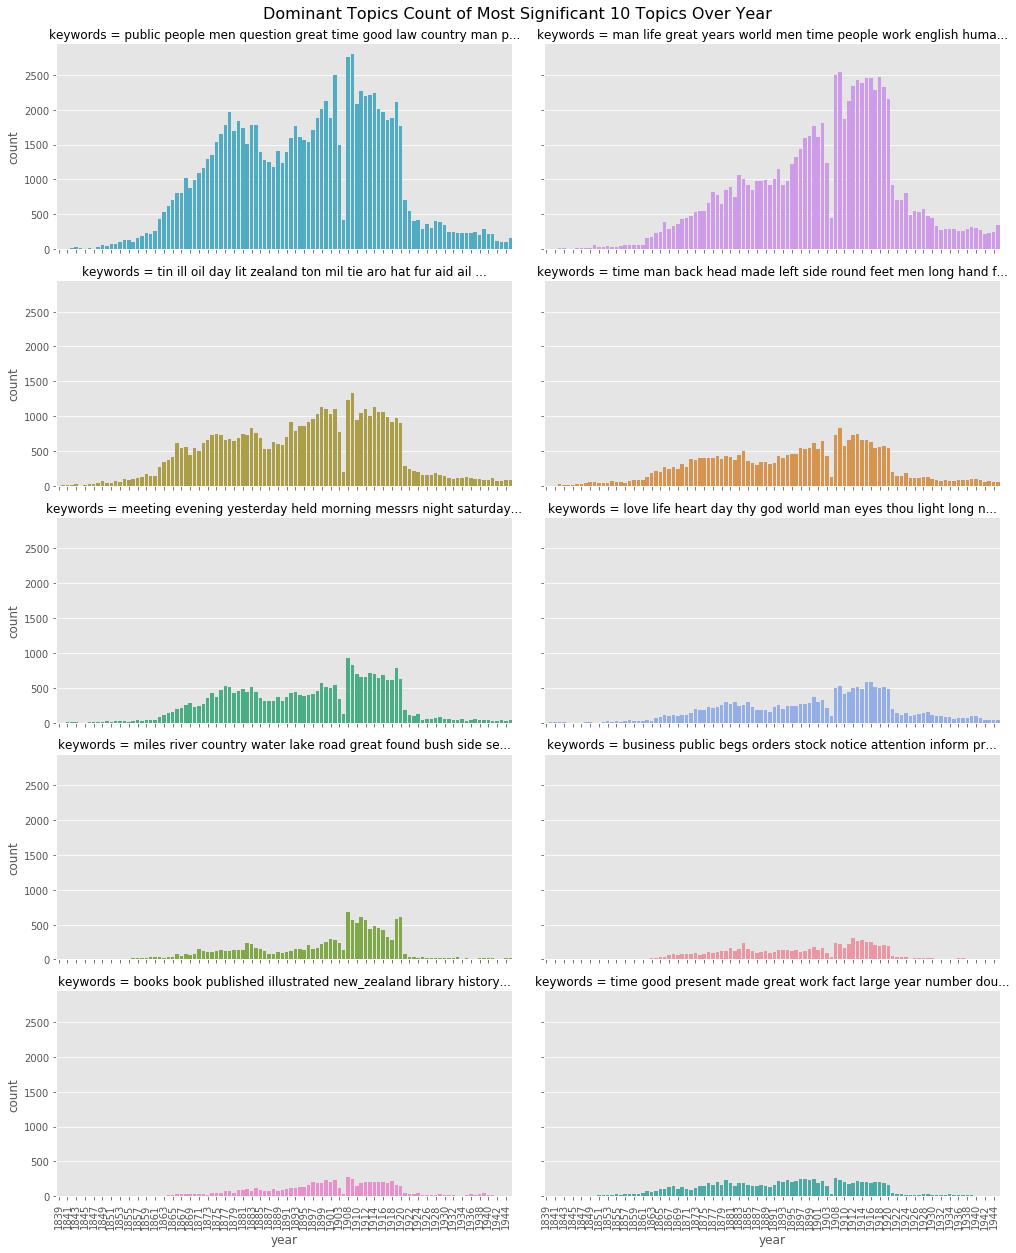

In [23]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

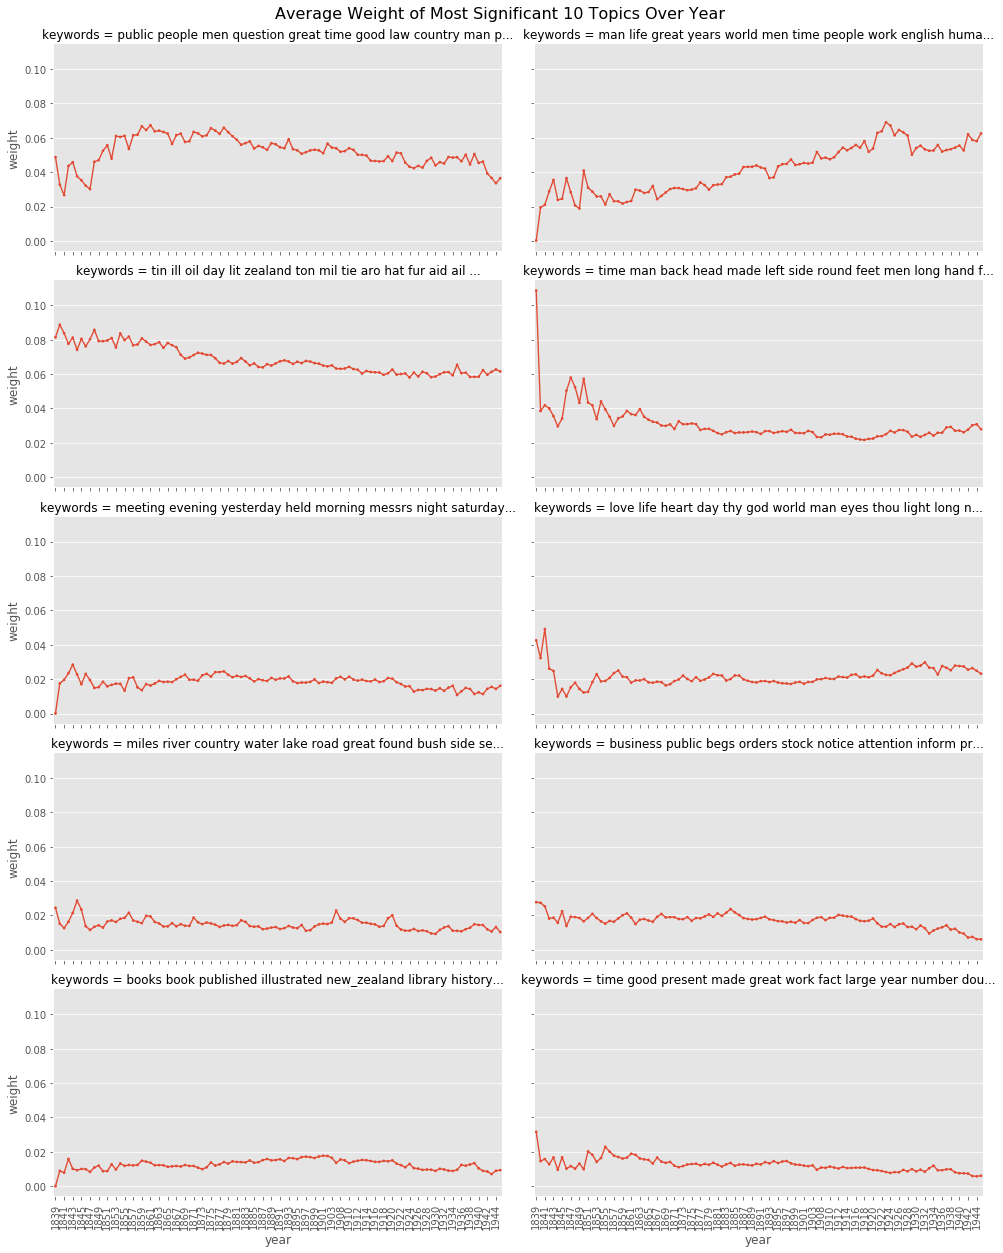

In [24]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

## 6 The Most Different Topics

**By compare the topic weight in topic list, we can find out which topics are the most different between ADs and non-ADs. Here we are interested in both trend (the more or less popular topics) in the ADs.**

In [25]:
path = r'../models/ads/topicKeysOthers.csv'

df_topics_others = (pd.read_csv(path, 
                                header=None, 
                                index_col=None, 
                                names = ['topic_', 'weight_', 'keywords_'],
                                encoding='utf8')
                    .sort_values(by='topic_')
                    .reset_index(drop=True))

df_diff = df_topics_others.join(df_topics)

# to find more populare topics
#df_diff['diff'] = (df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])
# to find more populare or contrary trend topics
df_diff['diff'] = abs(df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])

df_diff = df_diff.sort_values(by='diff', ascending=False)

topic_list = list(df_diff['topic'][:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [5, 188, 44, 141, 114, 46, 34, 50, 187, 181]
Shape of df_plt_dom: (699, 6)
Shape of df_plt_avg: (1040, 4)


,weight,keywords
topic,,
5,0.001394,association press received telegraph copyright london united electric july cable sydney august june april march aust...
188,0.000367,auckland wellington left due london lyttelton october september august november sydney december january march sailed...
44,0.001488,enemy german germans front french london british fighting troops attack received captured russian artillery line sta...
141,0.001552,association meeting conference union council committee new_zealand wellington held decided league members delegates ...
114,0.000551,funeral loving memory late inserted cemetery friends dear leave residence passed memoriam mother wife family attend ...
46,0.001382,john william james son daughter mrs thomas aged george years late wife henry charles residence mary robert wellingto...
34,0.001795,wellington arrived morning nelson sailed tons auckland to-morrow to-day port leaves yesterday coast westport passeng...
50,0.000979,wellington auckland dunedin christchurch canterbury new_zealand otago association north wanganui napier nelson press...
187,0.001222,men military private army camp officers service war new_zealand soldiers defence colonel officer captain training wo...


**Dominant topics distribution over year:**

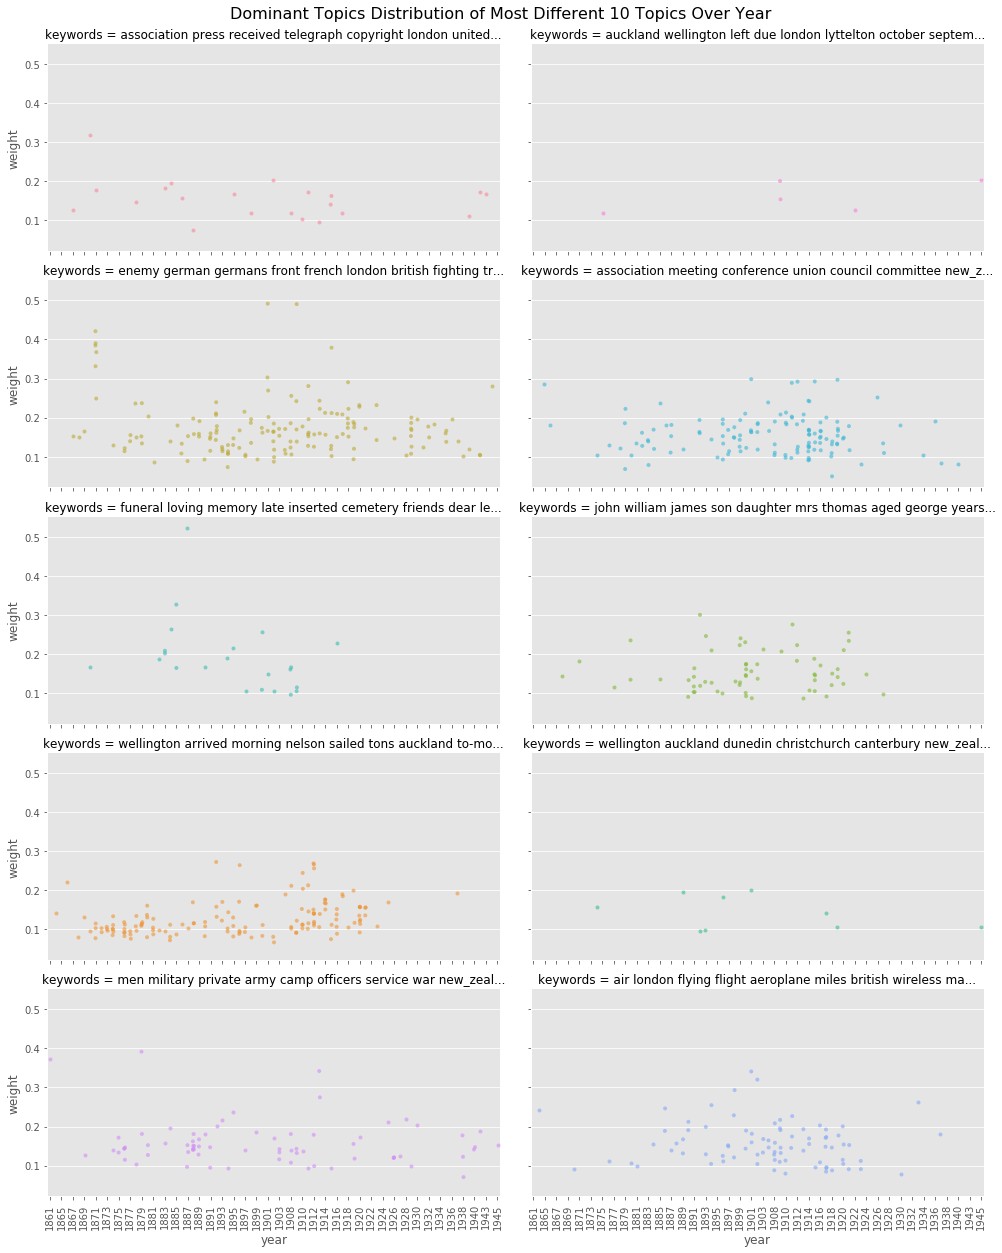

In [26]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

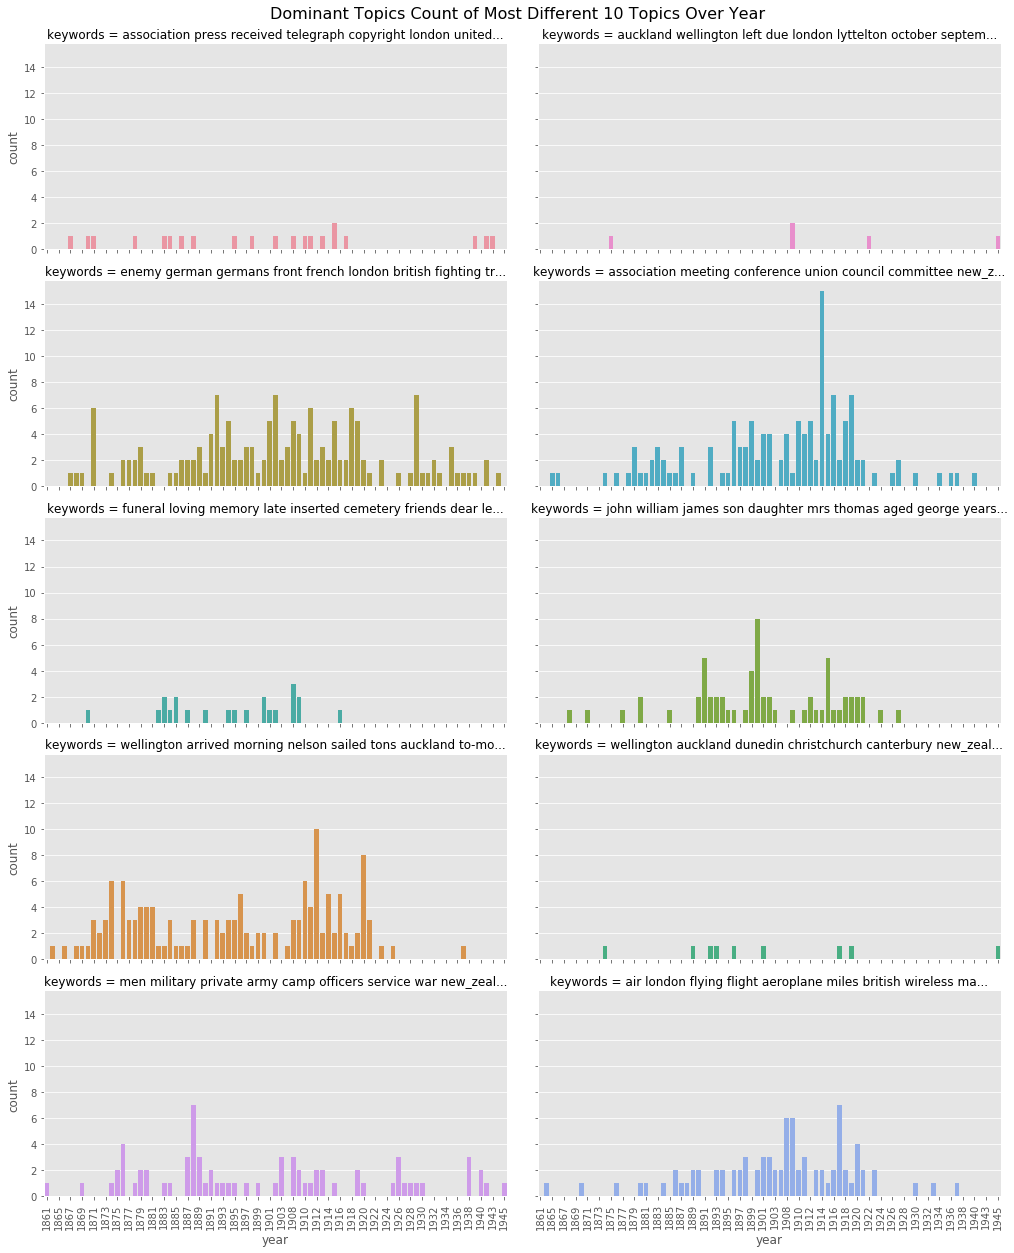

In [27]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

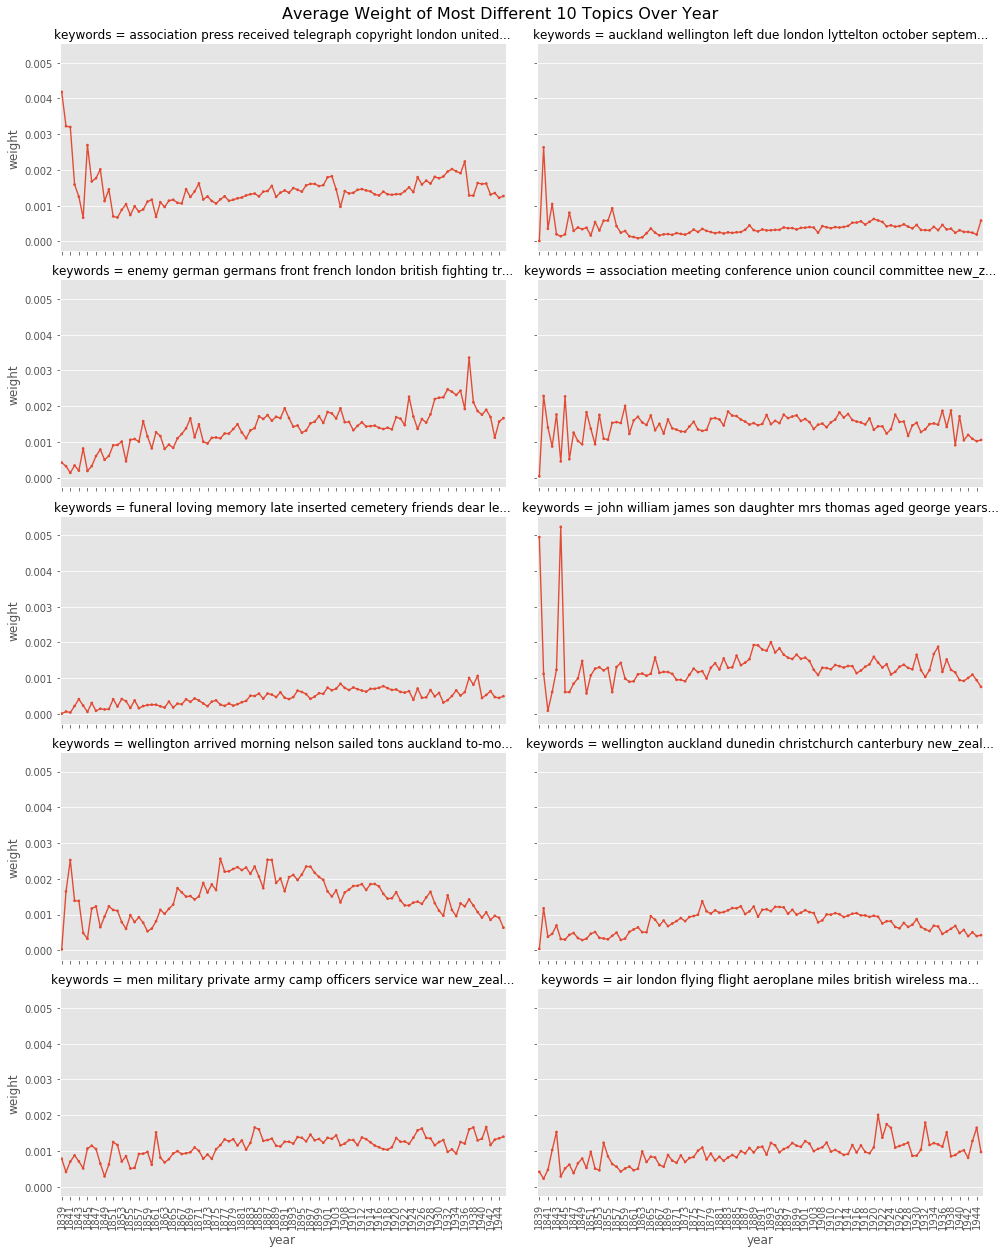

In [28]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

---

In [ ]:
gc.collect()